# Tutorial: Sequential Monte Carlo in Gen

In [1]:
using Gen
using Pkg
Pkg.status()

    Status `~/dev/gen-examples/Project.toml`
  [ea4f424c] ~ Gen v0.2.1 #master (https://github.com/probcomp/Gen) ⇒ v0.2.1 [`~/dev/Gen`]
  [1956f2fc]   GenTF v0.1.0 #master (https://github.com/probcomp/GenTF)
  [5a9e95f6]   GenViz v0.1.0 #master (https://github.com/probcomp/GenViz)
  [7073ff75]   IJulia v1.15.2
  [4138dd39]   JLD v0.9.1
  [eb30cadb]   MLDatasets v0.3.0
  [438e738f]   PyCall v1.18.5
  [d330b81b]   PyPlot v2.7.0
  [2913bbd2]   StatsBase v0.27.0
  [9a3f8284]   Random 
  [10745b16]   Statistics 


In [41]:
import Random
Random.seed!(1);

Show an HMM model, not using the unfold combinator:

In [7]:
function x_mean(x_prev::Real, t::Int)
    (x_prev / 2.) + 25 * (x_prev / (1 + x_prev * x_prev)) + 8 * cos(1.2 * t)
end

y_mean(x::Real) = (x * x / 20.)

@gen function hmm(var_x::Float64, var_y::Float64, T::Int)
    xs = Vector{Float64}(undef, T)
    ys = Vector{Float64}(undef, T)
    xs[1] = @addr(normal(0, 5), (:x, 1))
    ys[1] = @addr(normal(y_mean(xs[1]), sqrt(var_y)), (:y, 1))
    for t=2:T
        xs[t] = @addr(normal(x_mean(xs[t-1], t), sqrt(var_x)), (:x, t))
        ys[t] = @addr(normal(y_mean(xs[t]), sqrt(var_y)), (:y, t))
    end 
    return (xs, ys) 
end;

In [10]:
function render_trace(trace; show_data=true)
    (xs, ys) = get_retval(trace)
    subplot(2, 1, 1)
    plot(xs, color="black", linestyle="--")
    if show_data
        subplot(2, 1, 2)
        plot(ys, color="red");
    end
end;

Generate a synthetic data set:

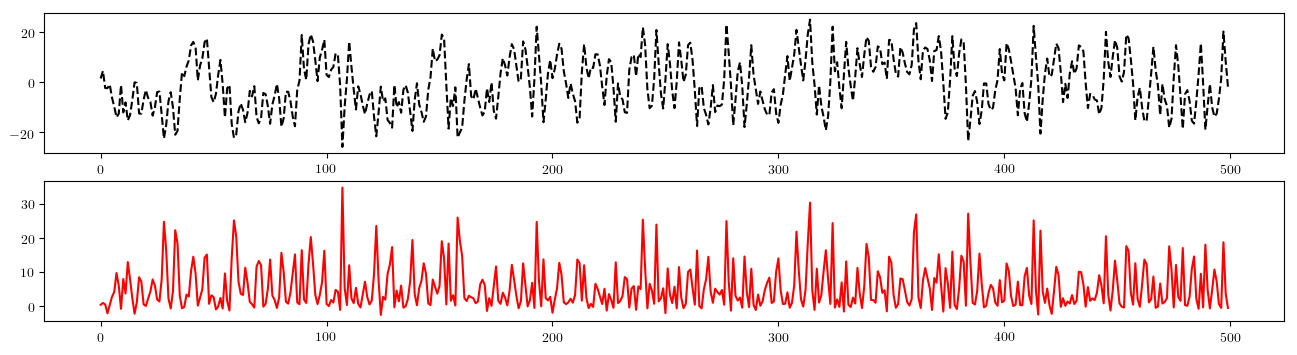

In [42]:
trace, _ = initialize(hmm, (10., 1., 500))
(xs, ys) = get_retval(trace)
figure(figsize=(16, 4))
render_trace(trace);

## Code used for both implementations

In [12]:
import Distributions

function effective_sample_size(log_normalized_weights::Vector{Float64})
    log_ess = -logsumexp(2. * log_normalized_weights)
    exp(log_ess)
end

function normalize_weights(log_unnormalized_weights::Vector{Float64})
    log_total_weight = logsumexp(log_unnormalized_weights)
    log_normalized_weights = log_unnormalized_weights .- log_total_weight
    (log_total_weight, log_normalized_weights)
end

function maybe_resample(traces::Vector{T}, log_weights::Vector{Float64};
                        ess_threshold::Float64=length(traces)/2) where {T}
    (log_total_weight, log_normalized_weights) = normalize_weights(log_weights)
    ess = effective_sample_size(log_normalized_weights)
    new_traces = Vector{T}(undef, length(traces))
    if ess < ess_threshold
        weights = exp.(log_normalized_weights)
        parents = Vector{Int}(undef, length(traces))
        Distributions.rand!(Distributions.Categorical(weights / sum(weights)), parents)
        increment = log_total_weight - log(length(traces))
        new_traces = traces[parents]
        new_log_weights = zeros(length(traces))
    else
        new_traces = traces
        new_log_weights = log_weights
        increment = 0.
    end
    (new_traces, new_log_weights, increment)
end;

## Particle filtering using unfold

version of the model that uses unfold:

In [32]:
@gen function kernel(t::Int, prev_x::Float64, var_x::Float64, var_y::Float64)
    x = @addr(normal(x_mean(prev_x, t), sqrt(var_x)), :x)
    y = @addr(normal(y_mean(x), sqrt(var_y)), :y)
    return x
end

chain = Unfold(kernel);

@gen function hmm_with_unfold(var_x::Float64, var_y::Float64, T::Int)
    @diff chain_argdiff = @argdiff()
    init_x = @addr(normal(0, 5), :init_x)
    @addr(normal(y_mean(init_x), sqrt(var_y)), :init_y)
    @addr(chain(T-1, init_x, var_x, var_y), :chain, chain_argdiff)
end;

trace rendering for the model for unfold

In [33]:
function render_trace_for_unfold(trace; show_data=true)
    choices = get_assmt(trace)
    T = get_args(trace)[3]
    xs = Vector{Float64}(undef, T)
    ys = Vector{Float64}(undef, T)
    xs[1] = choices[:init_x]
    ys[1] = choices[:init_y]
    for t=2:T
        xs[t] = choices[:chain => t-1 => :x]
        ys[t] = choices[:chain => t-1 => :y]
    end
    subplot(2, 1, 1)
    plot(xs, color="black", linestyle="--")
    if show_data
        subplot(2, 1, 2)
        plot(ys, color="red");
    end
end;

proposal for use with unfold:

In [34]:
@gen function proposal_for_unfold(prev_trace, t::Int)
    @assert t > 1
    var_x = Gen.get_args(prev_trace)[1]
    x_prev = Gen.get_assmt(prev_trace)[t > 2 ? (:chain => t-2 => :x) : :init_x]
    @addr(normal(x_mean(x_prev, t), sqrt(var_x)), :chain => t-1 => :x)
end;

a single step forward for the unfold model

In [35]:
unfold_argdiff = UnfoldCustomArgDiff(false, false)

function step_forward_for_unfold(traces::Vector{T}, log_weights::Vector{Float64}, y::Float64, t::Int) where {T}
    @assert t > 1
    new_traces = Vector{T}(undef, length(traces))
    new_log_weights = copy(log_weights)
    observation = DynamicAssignment((:chain => t-1 => :y, y))
    args = Gen.get_args(traces[1])
    new_args = (args[1], args[2], t) # increment t
    for i=1:length(traces)
        @assert args[3] == t-1
        choices = Gen.get_assmt(traces[i])
        (prop_choices, prop_weight, _) = Gen.propose(proposal_for_unfold, (traces[i], t))
        constraints = merge(observation, prop_choices)
        (new_traces[i], up_weight, disc, _) = Gen.force_update(new_args, unfold_argdiff, traces[i], constraints)
        @assert isempty(disc)
        new_log_weights[i] += up_weight - prop_weight
    end
    (new_traces, new_log_weights)
end;

getting the intial traces for the unfold model (using the prior as the proposal for :init_x)

In [36]:
function get_initial_traces_for_unfold(var_x::Float64, var_y::Float64, n::Int, y1::Float64)
    traces = Vector{Any}(undef, n)
    log_weights = Vector{Float64}(undef, n)
    constraints = Gen.DynamicAssignment((:init_y, y1))
    for i=1:n
        (traces[i], log_weights[i]) = Gen.initialize(hmm_with_unfold, (var_x, var_y, 1), constraints)
    end
    (traces, log_weights)
end;

particle filtering for unfold model

In [37]:
function do_particle_filter_for_unfold(ys::Vector{Float64}, num_particles)
    (traces, log_weights) = get_initial_traces_for_unfold(10., 1., num_particles, ys[1]);
    log_ml_est = 0.
    for t=2:length(ys)
        y = ys[t]
        (traces, log_weights) = step_forward_for_unfold(traces, log_weights, y, t)
        (traces, log_weights, incr) = maybe_resample(traces, log_weights)
        log_ml_est += incr
    end
    (traces, log_weights, log_ml_est)
end;

test it:


In [54]:
function timing_experiment(ns::Vector{Int})
    times = Vector{Float64}()
    times_unfold = Vector{Float64}()
    for n in ns
        tstart = time_ns()
        (traces, log_weights, log_ml_est) = do_particle_filter_for_unfold(ys[1:n], 1000)
        push!(times_unfold, (time_ns() - tstart) / 1e9)
        tstart = time_ns()
        (traces, log_weights, log_ml_est) = do_particle_filter(ys[1:n], 1000)
        push!(times, (time_ns() - tstart) / 1e9)
    end
    (times, times_unfold)
end;

In [55]:
ns = [1, 5, 10, 20, 30, 40, 50, 100, 150, 200]
(times, times_unfold) = timing_experiment(ns)

([0.00219052, 0.0674044, 0.195075, 0.66231, 1.44897, 2.36352, 3.69379, 17.1154, 38.145, 66.2272], [0.00333834, 0.123209, 0.25678, 0.654523, 1.24005, 1.30956, 1.63616, 3.53254, 5.64459, 8.0859])

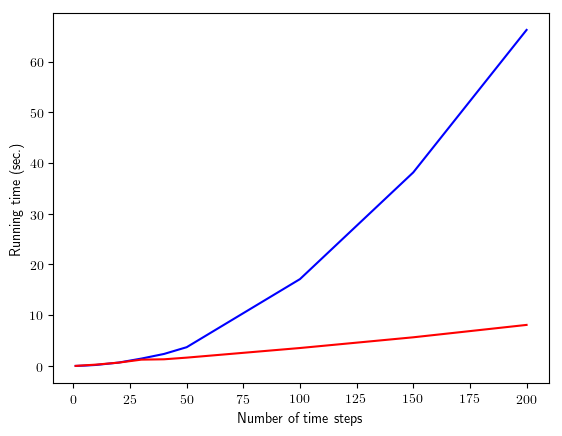

PyObject Text(24.000000000000014, 0.5, 'Running time (sec.)')

In [58]:
plot(ns, times, color="blue")
plot(ns, times_unfold, color="red")
xlabel("Number of time steps")
ylabel("Running time (sec.)");

## Particle filtering not using unfold

In [24]:
(traces, log_weights, log_ml_est) = do_particle_filter(ys, 1000);

function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

figure(figsize=(16,4))
overlay(render_trace, traces, same_data=true)

UndefVarError: UndefVarError: do_particle_filter not defined

In [25]:
@gen function proposal(prev_trace, t::Int)
    var_x = Gen.get_args(prev_trace)[1]
    x_prev = Gen.get_assmt(prev_trace)[(:x, t-1)]
    @addr(normal(x_mean(x_prev, t), sqrt(var_x)), (:x, t))
end;

In [26]:
function get_initial_traces(var_x::Float64, var_y::Float64, n::Int, y1::Float64)
    traces = Vector{Any}(undef, n)
    log_weights = Vector{Float64}(undef, n)
    constraints = Gen.DynamicAssignment(((:y, 1), y1))
    for i=1:n
        (traces[i], log_weights[i]) = Gen.initialize(hmm, (var_x, var_y, 1), constraints)
    end
    (traces, log_weights)
end;

In [27]:
(traces, log_weights) = get_initial_traces(10., 1., 1000, 0.5);

In [28]:
function step_forward(traces::Vector{T}, log_weights::Vector{Float64}, y::Float64, t::Int) where {T}
    @assert t > 1
    new_traces = Vector{T}(undef, length(traces))
    new_log_weights = copy(log_weights)
    observation = DynamicAssignment(((:y, t), y))
    args = Gen.get_args(traces[1])
    new_args = (args[1], args[2], t) # increment t
    for i=1:length(traces)
        @assert args[3] == t-1
        choices = Gen.get_assmt(traces[i])
        x_prev, y_prev = (choices[(:x, t-1)], choices[(:y, t-1)])
        (prop_choices, prop_weight, _) = Gen.propose(proposal, (traces[i], t))
        constraints = merge(observation, prop_choices)
        (new_traces[i], up_weight, disc, _) = Gen.force_update(new_args, Gen.unknownargdiff, traces[i], constraints)
        @assert isempty(disc)
        new_log_weights[i] += up_weight - prop_weight
    end
    (new_traces, new_log_weights)
end;

In [29]:
function do_particle_filter(ys::Vector{Float64}, num_particles)
    (traces, log_weights) = get_initial_traces(10., 1., num_particles, ys[1]);
    log_ml_est = 0.
    for t=2:length(ys)
        y = ys[t]
        (traces, log_weights) = step_forward(traces, log_weights, y, t)
        (traces, log_weights, incr) = maybe_resample(traces, log_weights)
        log_ml_est += incr
    end
    (traces, log_weights, log_ml_est)
end;

In [30]:
(traces, log_weights, log_ml_est) = do_particle_filter([1., 2., 1., 2., 1., 2., 1.], 10000);

## 2. Particle filtering with a default proposal

use the nonlinear state space model from the PMMH paper (with fixed global parameters)

## 3. Particle filtering with rejuvenation moves

in the nonlinear state space model from the PMMH paper, do rejuvenation moves on the global parameters?

## 4. Particle Marginal Metropolis Hastings

do PMMH in the nonlinear state space model

## 5. Particle filtering with a custom proposal

use the 'motion along path' model

compare the default and custom proposals